In [ ]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

os.chdir(f'/content/drive/MyDrive/')
os.getcwd()
rootfolder = './Colab Notebooks/NLP'

Useful function for plot the 2D DCT dictionary

In [ ]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [ ]:
def OMP(s, D, L, tau):
  M, N = D.shape
  x = np.zeros(N)
  # residual
  r = s - np.dot(D, x)
  resNorm = np.linalg.norm(r)

  # support set
  omega = []
  while np.count_nonzero(x) < L and resNorm > tau: #STOPPING CRITERIA:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        zj = np.dot(r.T,D[:,j])**2/np.linalg.norm(D[:,j])**2
        e[j] = np.linalg.norm(r)**2 - zj

    # find the column of D that matches at best r
    jStar = np.argmin(e)

    # UPDATE the support set with the jStar coefficient
    if jStar not in omega:
        omega.append(jStar)

    # update the coefficients by solving the least square problem min ||D_omega x - s ||
    x[omega] = np.dot(np.linalg.inv((D[:,omega].T @ D[:,omega])),D[:,omega].T @ s)

    # update the residual
    r = s - np.dot(D, x)
    resNorm = np.linalg.norm(r)


  return x

Load the image and rescale it in $[0,1]$

In [ ]:
img = imread(f'{rootfolder}/data/peppers256.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2

Corrupt the image with white gaussian noise

In [ ]:
sigma_noise = 20/255
noisy_img = img + sigma_noise * np.random.randn(*imsz)

Percentage of removed pixel

In [ ]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [ ]:
# create a vector with all the indexes of the image
idx = np.arange(imsz[0] * imsz[1])

# shuffle it and take the target percentage of indexes
idx = np.random.permutation(idx)
idx = idx[:int(len(idx)*perc_of_removed_pixels)]

# the mask is 0 for the chosen idx, 1 elsewhere
msk = np.ones(imsz)
msk.ravel()[idx] = 0

# apply the mask: set to 0 some elements in the noisy image
noisy_img = noisy_img * msk

Compute the psnr of the noisy input

In [ ]:
def psnr(oimg,nimg):
    return 10*np.log10(1/np.mean((oimg-nimg)**2))

In [ ]:
psnr_noisy = psnr(img,noisy_img.reshape(imsz))


Text(0.5, 1.0, 'Dead pixels')

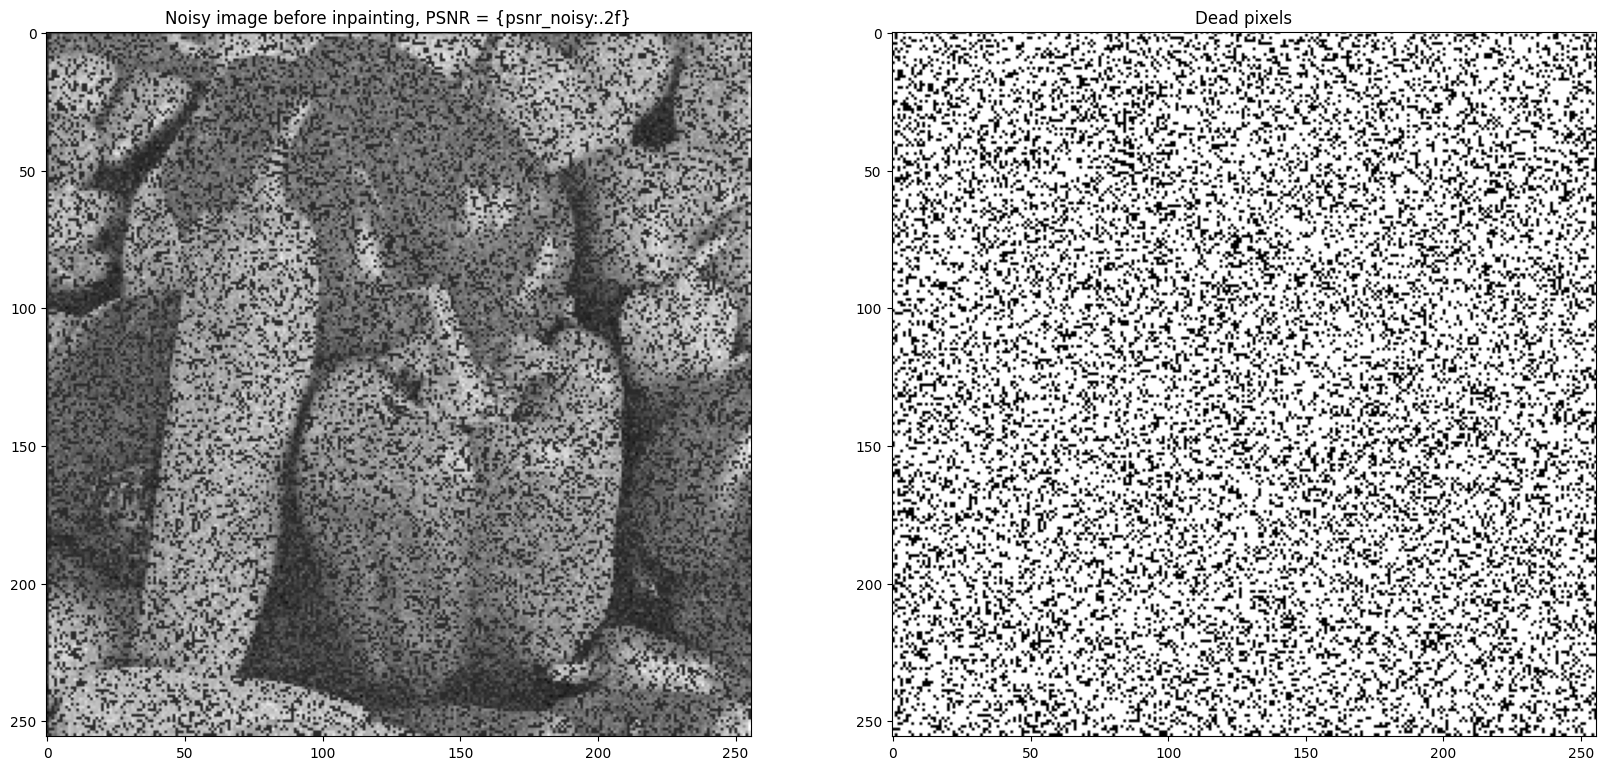

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap='gray')
ax[0].set_title('Noisy image before inpainting, PSNR = {psnr_noisy:.2f}')

ax[1].imshow(msk, cmap='gray')
ax[1].set_title(f'Dead pixels')


Load and display the dictionary learned from patches

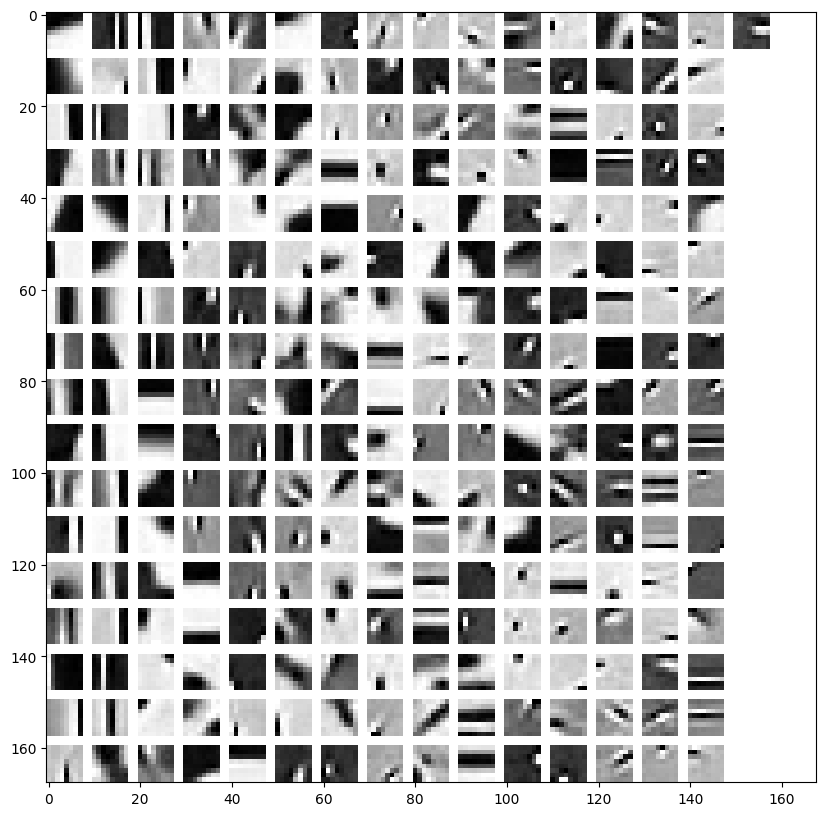

In [ ]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
# UPDATE D
D = np.hstack((D, np.ones((D.shape[0], 1))))

# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Inpainting
----------


In [ ]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [ ]:

for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i:i+p, j:j+p].flatten()

        # patch extracted from the mask
        m = msk[i:i+p, j:j+p].flatten()

        # design the projection operator over the current patch
        proj = np.diag(m)

        # tau should be proportional to the number of pixels remaining in the patch
        tau = 1.115 * sigma_noise * np.sqrt(np.count_nonzero(m))

        # sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        x = OMP(s, proj@D , L, tau)

        # reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = D@x

        # use uniform weights for aggregation
        w = 1

        # put the denoised patch into the estimated image using uniform weights
        # UPDATE img_hat
        img_hat[i:i+p, j:j+p] += s_hat.reshape(p, p)

        # store the weight of the current patch in the weight matrix
        # UPDATE weights
        weights[i:i+p, j:j+p] += 1

Normalize the estimated image with the computed weights

In [ ]:
img_hat = img_hat/weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 28.45')

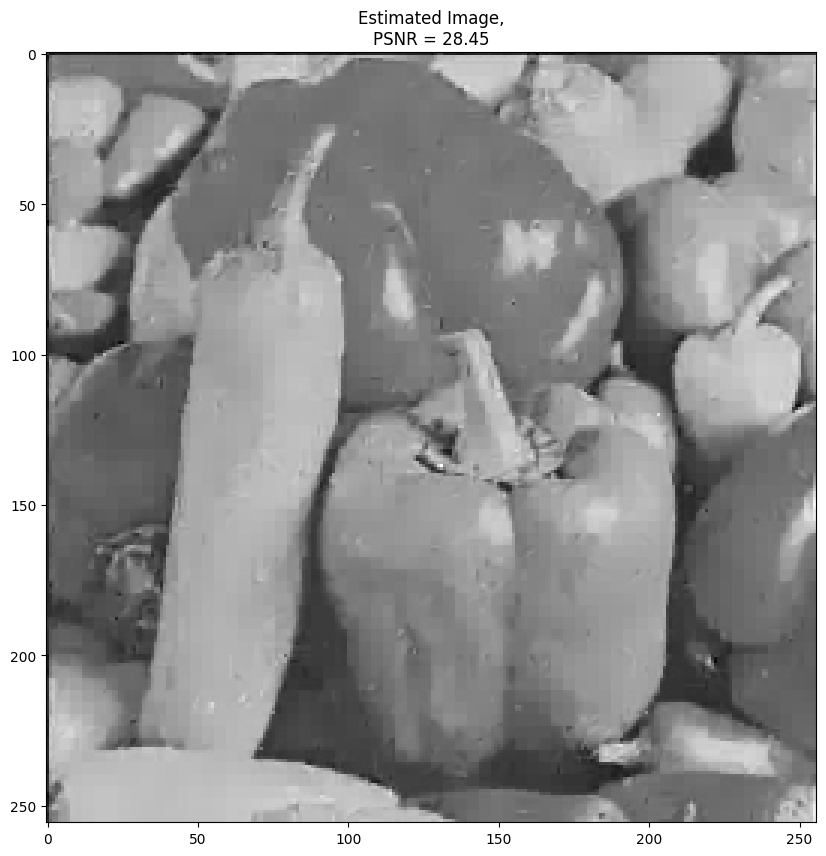

In [ ]:
psnr_hat = psnr(img,img_hat)
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
